In [23]:
import numpy as np
from itertools import combinations
from ktsp import KTopScoringPairs
import importlib
import utils
importlib.reload(utils)
import importlib
import  hierarchical_classifier
importlib.reload(hierarchical_classifier)

<module 'hierarchical_classifier' from 'C:\\Users\\Administrator\\hierarchical_classifier.py'>

In [20]:

# define for dataset
datasets = {
    #"Leukemia": r"D:\fitchburg\Bu_ML\Data\Leukemia.txt"
    #"Colon": r"D:\fitchburg\Bu_ML\Data\Colon.txt"
    #"DLBCL": r"D:\fitchburg\Bu_ML\Data\DLBCL.txt"
    "LUNG": r"D:\fitchburg\Bu_ML\Data\Lung.txt"
    #"GCM": r"D:\fitchburg\Bu_ML\Data\GCM.txt"
    #"prostate1":r"D:\fitchburg\Bu_ML\Data\prostate1.txt"
    #"prostate2":r"D:\fitchburg\Bu_ML\Data\prostate2.txt"
    #"prostate3": r"D:\fitchburg\Bu_ML\Data\prostate3.txt"
}



# example
X, y, labels, unique_labels = utils.load_dataset("LUNG", datasets)
print("Data shape:", X.shape)
print("y shape:", y.shape)
print("Labels:", labels[:10])
print("Unique labels:", unique_labels)


Data shape: (12533, 181)
y shape: (181,)
Labels: ['mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma', 'mesothelioma']
Unique labels: ['adca', 'mesothelioma']


In [21]:
# 2. define K-TSP base_model
def ktsp_base_model(X, y, k=3):
    clf = KTopScoringPairs(K=k)
    clf.fit(X, y)
    return clf

Processing dataset:LUNG
Building node:
  classes: [0 1]
  X.shape: (300, 144)
  y.shape: (144,)
Building node: classes=[0 1], X.shape=(300, 144), y.shape=(144,)
Building node:
  classes: [0]
  X.shape: (300, 119)
  y.shape: (119,)


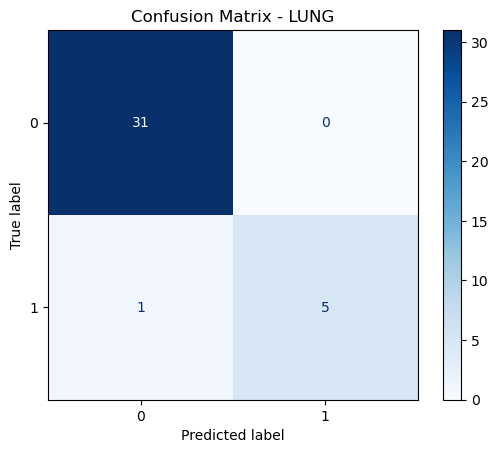

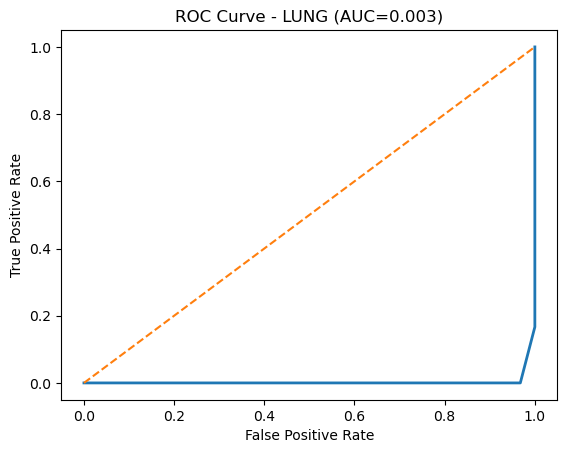

Dataset LUNG: K-TSP accuracy = 0.9730
All K-TSP pairs in the hierarchy: [[(36, 120), (26, 185), (74, 185), (49, 185), (34, 185), (32, 185), (25, 120), (85, 185), (151, 185), (150, 185)]]


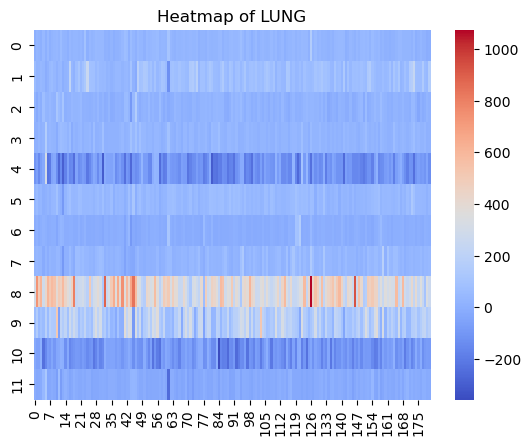

In [24]:
# processing dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

for name in datasets:
    print(f"Processing dataset:{name}")
    
    #loaddataset
    X,y,labels,unique_labels=utils.load_dataset(name,datasets)
    
    #initialize K-TSP
    #ktsp= KTopScoringPairs(K=3)
    #kstp.fit(X,y)
    
    #Classifier 
    #hclf= HierarchicalClassifier(base_model=lambda Xb, yb: ktsp_base_model(Xb.T, yb, k=10))

    train_idx, test_idx = train_test_split(np.arange(X.shape[1]),  test_size=0.2, random_state=42,stratify=y)
    
    X_train = X[:, train_idx]
    y_train = y[train_idx]

    X_test = X[:, test_idx]
    y_test = y[test_idx]
    
    ##X_train, X_test, y_train, y_test = train_test_split(X_small.T, y, test_size=0.2, random_state=42)
    #Choose the trainset
    X_train_small, selected_idx = utils.select_top_var_genes(X_train, top=300)
    X_test_small = X_test[selected_idx, :]
    
    #train HC + K-TSP
    hclf = hierarchical_classifier.HierarchicalClassifier(base_model=lambda Xb, yb: ktsp_base_model(Xb, yb, k=10))
    
    hclf.fit(X_train_small, y_train)
    
    #predictor 
    y_pred = hclf.predict(X_test_small)
    scores = hclf.predict_score(X_test_small) 
    
    #Calculate Accuracy rate
    accuracy = np.mean(y_pred == y_test)
    
    #for matrix confusing
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.unique(y))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    # ---- ROC Curve (binary only) ----
    if len(np.unique(y)) == 2:
        scores = hclf.decision_function(X_test_small)
        y_bin = (y_test == np.unique(y)[1]).astype(int)

        fpr, tpr, thresholds = roc_curve(y_bin, scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2)
        plt.plot([0, 1], [0, 1], '--')
        plt.title(f"ROC Curve - {name} (AUC={roc_auc:.3f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
    
    print(f"Dataset {name}: K-TSP accuracy = {accuracy:.4f}")
    print("All K-TSP pairs in the hierarchy:", hclf.get_all_pairs())
    pairs = hclf.get_all_pairs()[0]
    genes = list(set([i for i,j in pairs] + [j for i,j in pairs]))

    sns.heatmap(X[genes, :], cmap="coolwarm")
    plt.title(f"Heatmap of {name}")  #
    plt.show()